# Interleaved Randomized Benchmarking (IRB)


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/apps/supermarq/qcvv/qcvv_irb_css.ipynb)
[![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/apps/supermarq/qcvv/qcvv_irb_css.ipynb)


The interleaved randomized benchmarking routine allows us to estimate the fidelity of single and two
qubit Clifford operations. To demonstrate this routine, consider device noise modelled by an
amplitude damping channel with decay probability $\gamma=0.05$. We want to estimate the fidelity of
the single-qubit $Z$ gate.


In [1]:
import cirq
import numpy as np
import supermarq

In [2]:
decay_prob = 0.05
noise = cirq.AmplitudeDampingChannel(gamma=decay_prob)
simulator = cirq.DensityMatrixSimulator(noise=noise)

We can calculate the average fidelity of this channel
[as](https://quantumcomputing.stackexchange.com/questions/16074/how-to-calculate-the-average-fidelity-of-an-amplitude-damping-channel):

$$
\begin{align}
\overline{F} &= \int\langle\psi|\mathcal{N_\gamma}(|\psi\rangle\langle\psi|)|\psi\rangle d\psi\\
&=\int\langle\psi|K_0|\psi\rangle\langle\psi|K_0^\dagger|\psi\rangle + \langle\psi|K_1|\psi\rangle\langle\psi|K_1^\dagger|\psi\rangle d\psi\\
& =\frac{1}{4\pi}\int_0^\pi\int_0^{2\pi}\left|\begin{pmatrix}\cos\frac{\theta}{2}&e^{-i\phi}\sin\frac{\theta}{2}\end{pmatrix}\begin{pmatrix}1 & 0 \\0 & \sqrt{1 - \gamma}\end{pmatrix}\begin{pmatrix}\cos\frac{\theta}{2}\\e^{i\phi}\sin\frac{\theta}{2}\end{pmatrix}\right|^2\sin\theta \\
& + \left|\begin{pmatrix}\cos\frac{\theta}{2}&e^{-i\phi}\sin\frac{\theta}{2}\end{pmatrix}\begin{pmatrix}0 & \sqrt{\gamma} \\0 & 0\end{pmatrix}\begin{pmatrix}\cos\frac{\theta}{2}\\e^{i\phi}\sin\frac{\theta}{2}\end{pmatrix}\right|^2\sin\theta d\phi d\theta \\
&=\frac{1}{4\pi}\int_0^\pi\int_0^{2\pi}\left|\cos^2\frac{\theta}{2}+\sqrt{1-\gamma}\sin^2\frac{\theta}{2}\right|^2\sin\theta + \left|\sqrt{\gamma}e^{i\phi}\sin\frac{\theta}{2}\cos\frac{\theta}{2}\right|^2\sin\theta d\phi d\theta \\
&=\frac{1}{2}\int_0^\pi\left(\cos^4\frac{\theta}{2}+(1-\gamma)\sin^4\frac{\theta}{2}+\frac{\sqrt{1-\gamma}}{2}\sin^2\theta + \frac{\gamma}{4}\sin^2\theta\right)\sin\theta d\theta \\
&=\frac{1}{2}\int_0^\pi\sin\theta\cos^4\frac{\theta}{2}+(1-\gamma)\sin\theta\sin^4\frac{\theta}{2}+\frac{\gamma+2\sqrt{1-\gamma}}{4}\sin^3\theta d\theta \\
&=\frac{1}{2}\left(\frac{2}{3} + (1-\gamma)\frac{2}{3} + \frac{\gamma+2\sqrt{1-\gamma}}{4}\frac{4}{3}\right) \\
&=\frac{1}{2}\left(\frac{4}{3} - \frac{\gamma}{3} + \frac{2\sqrt{1-\gamma}}{3}\right) \\
&=\frac{2}{3}-\frac{\gamma}{6} + \frac{\sqrt{1-\gamma}}{3}.
\end{align}
$$


Thus we have a gate error $$\frac{1}{3}+\frac{\gamma}{6} - \frac{\sqrt{1-\gamma}}{3}$$


In [3]:
expected_gate_error = 1 / 3 + decay_prob / 6 - np.sqrt(1 - decay_prob) / 3

Now we run the experiments and analyse the results.


In [4]:
experiment = supermarq.qcvv.IRB(150, [2, 6, 15, 20, 30], interleaved_gate=cirq.Z)
result = experiment.run_with_simulator(simulator=simulator)

Building circuits:   0%|          | 0/750 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/1500 [00:00<?, ?it/s]

Estimated gate error: 0.020538 +/- 0.003241


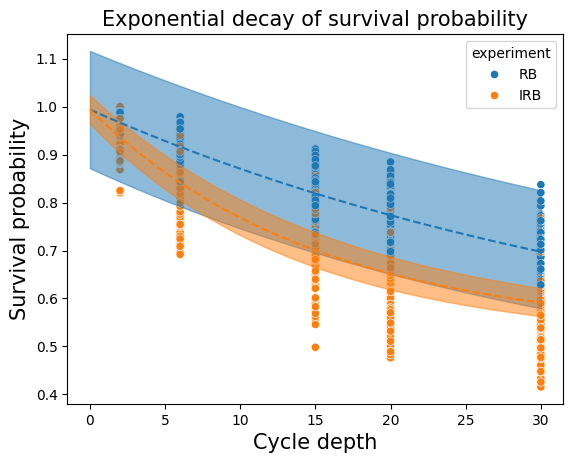

In [5]:
result.analyze()

In [6]:
print(f"Expected gate error: {expected_gate_error:.6f}")
print(
    f"Measured gate error: {result.average_interleaved_gate_error:.6f} +/- {result.average_interleaved_gate_error_std:.6f}"
)

Expected gate error: 0.016774
Measured gate error: 0.020538 +/- 0.003241


So our estimate is in good agreement with the expected result.


## Two Qubit RB

The `IRB()` routine can also perform vanilla Randomised Benchmarking (RB) by instead passing
`interleaved_gate=None`. We demonstrate this with a two qubit depolarising noise model with an error
of $0.02$.


First we have to define a custom noise model.


In [7]:
class TwoQubitDepolariseNoiseModel(cirq.NoiseModel):
    """Applies two qubit depolarising channels"""

    def __init__(self, average_qubit_error: float) -> None:
        """Args:
        average_qubit_error: The average two qubit error rate
        """
        super().__init__()
        # Note the conversion from average error to pauli error which is used by the cirq channel.
        self.two_qubit_pauli_error = 15 / 16 * 4 / 3 * average_qubit_error
        self.two_qubit_depolarise = cirq.DepolarizingChannel(
            p=self.two_qubit_pauli_error, n_qubits=2
        )

    def noisy_operation(self, operation: cirq.Operation) -> list[cirq.OP_TREE]:
        """Produces a list of operations by applying each noise model
        to the provided operation depending on the number of qubits it acts on.
        """
        if len(operation.qubits) == 2:
            return [operation, self.two_qubit_depolarise(*operation.qubits)]

        return [operation]


two_qubit_noise = TwoQubitDepolariseNoiseModel(two_qubit_error := 0.02)
two_qubit_simulator = cirq.DensityMatrixSimulator(
    noise=two_qubit_noise,
)

Now run the experiment and analyse the results


In [8]:
experiment2 = supermarq.qcvv.IRB(50, [2, 6, 15, 20, 30], interleaved_gate=None, num_qubits=2)
results2 = experiment2.run_with_simulator(simulator=two_qubit_simulator)

Building circuits:   0%|          | 0/250 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/250 [00:00<?, ?it/s]

Estimated error per Clifford: 0.026810 +/- 0.001858


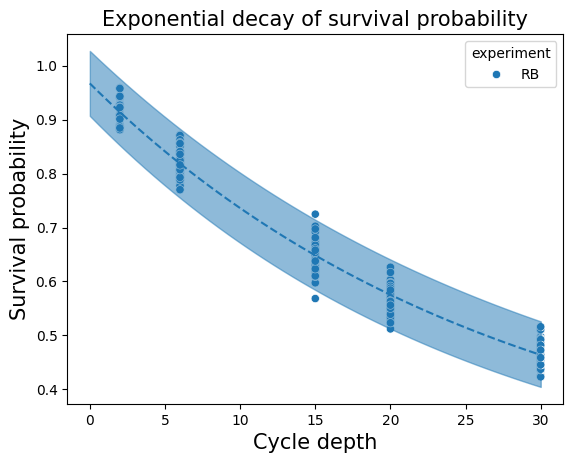

In [9]:
results2.analyze()

In [10]:
gpc = experiment2.gates_per_clifford()

print(f"Expected average gate error: {two_qubit_error:.6f}")
print(
    f"Measured average gate error: {results2.average_error_per_clifford / gpc['two_qubit_gates']:.6f} +/- {results2.average_error_per_clifford_std / gpc['two_qubit_gates']:.6f}"
)

Sampling Clifford operations:   0%|          | 0/500 [00:00<?, ?it/s]

Expected average gate error: 0.020000
Measured average gate error: 0.017615 +/- 0.001221


Note that because randomised benchmarking measures the error per Clifford operation, we have to take
into account how many two qubit gates are used on average to implement a two qubit Clifford
operation.

We see that the measured two qubit gate error is in good agreement with the true value used by
the simulator.
